In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, random
from tqdm import tqdm
from PIL import Image

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn

from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import models
from transformers import Dinov2Model

device = torch.device('mps')

from src.train_functions import train_epoch, validate_epoch


/Users/k.choi/opt/miniconda3/envs/pytorch_csiro/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
project_dir     = '/Users/k.choi/Documents/github/csiro_git'
data_dir        = os.path.join(project_dir, 'data')
model_dir       = os.path.join(project_dir, 'models'); os.makedirs(model_dir, exist_ok=True)

csv_data        = pd.read_csv(os.path.join(data_dir, 'train.csv'))
target_names    = csv_data['target_name'].unique()

In [3]:
def preprocess_data(df, target_names = ['Dry_Green_g','Dry_Total_g','GDM_g']):
    unqiue_path = df['image_path'].unique()
    data_list = []
    for uni_path in unqiue_path:

        data = df[df['image_path'] == uni_path]
        row   = {'image_path': uni_path} 

        for tar in target_names: 
            row[tar] = data[data['target_name'] == tar]['target'].values[0]
            
        data_list.append(row)   

    return pd.DataFrame(data_list)

In [4]:
data = preprocess_data(csv_data)

train_data, test_data = train_test_split(data, test_size=0.02, random_state=8964)
train_data, valid_data  = train_test_split(train_data, test_size=0.2, random_state=8964)

print(f"train data: {len(train_data)}")
print(f"valid data: {len(valid_data)}")
print(f"test data: {len(test_data)}")


train data: 279
valid data: 70
test data: 8


In [5]:
class BiomassDS(Dataset):
    def __init__(self, df, data_dir, transform, target_names = ['Dry_Green_g','Dry_Total_g','GDM_g']):
        self.df = df.reset_index(drop=True)
        self.data_dir = data_dir
        self.transform = transform
        self.target_names = target_names
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row['image_path'])
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)
        targets = torch.tensor([row[col] for col in self.target_names], dtype=torch.float32)
        return image, targets 

In [6]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

batch_size = 16 
WORKERS = 0

class rand_rota:
    def __call__(self, img):
        angle = np.random.choice([0,90,180,270])
        return transforms.functional.rotate(img, int(angle))

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    # rand_rota(),
    transforms.RandomHorizontalFlip(p=0.5), transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)])
valid_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), transforms.Normalize(mean=mean, std=std) ])

train_ds = BiomassDS(df =train_data, data_dir=data_dir, transform=train_transform)
valid_ds = BiomassDS(df =valid_data, data_dir=data_dir, transform=valid_transform)
test_ds  = BiomassDS(df =test_data,  data_dir=data_dir, transform=valid_transform)
assert len(train_ds) == len(train_data) and len(valid_ds) == len(valid_data)

train_loader = DataLoader(train_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=True  , pin_memory=False)
valid_loader = DataLoader(valid_ds, batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, num_workers=WORKERS, shuffle=False , pin_memory=False)

In [ ]:
class get_dino(nn.Module):

    def __init__(self, backbone, patch_dim, num_targets=3):
        super().__init__()
        self.backbone = backbone  
        for params in self.backbone.parameters(): params.requires_grad = False
        
        self.heads = nn.Sequential(
            nn.Linear(patch_dim, 512),nn.LayerNorm(512),nn.GELU(),nn.Dropout(0.3),
            nn.Linear(512, 256),nn.LayerNorm(256),nn.GELU(),nn.Dropout(0.3),
            nn.Linear(256, num_targets))

    def forward(self, x):
        with torch.no_grad():
            outputs = self.backbone(x)
            patch_features = outputs.last_hidden_state[:, 1:, :] ### (batch_size, 256, 384)
        b, n, d = patch_features.shape 
        patch_preds = self.heads(patch_features.reshape(-1, d)).reshape(b, n, -1)  
        avg_pred = torch.mean(patch_preds, dim=1) ### (batch_size, num_targets)
        return avg_pred

In [8]:
# fig, axes = plt.subplots(1,6, figsize=(10,3))
# img0 = Image.open(os.path.join(data_dir, random.choice( train_data['image_path'].unique())))

# for i, ax in enumerate(axes):
#     if i ==0: 
#         ax.imshow(img0)
#         ax.axis('off')
#         continue

#     img = train_transform(img0)
#     mean = torch.tensor( [0.485, 0.456, 0.406] ).view(3,1,1)
#     std  = torch.tensor( [0.229, 0.224, 0.225] ).view(3,1,1)
#     img = img * std + mean
#     img = img.clamp(0,1).permute(1,2,0).numpy()
#     ax.imshow(img)
#     ax.axis('off')
# plt.tight_layout();plt.show()

In [11]:
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-small'); patch_dim = 384
# dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-base'); patch_dim = 768
dinov2 = Dinov2Model.from_pretrained('facebook/dinov2-large'); patch_dim = 1024
dinov2.eval(); dinov2.to(device);

In [12]:
model = get_dino(dinov2, patch_dim=patch_dim, num_targets=3); model.to(device) 

all_params = sum(p.numel() for p in model.parameters()); print(f"Total parameters: {all_params}")
train_params = sum(p.numel() for p in model.heads.parameters());print(f"Trainable parameters: {train_params}")
frozen_params = sum(p.numel() for p in model.backbone.parameters());print(f"Frozen parameters: {frozen_params}")

Total parameters: 305027075
Trainable parameters: 658435
Frozen parameters: 304368640


In [13]:
LR = 1e-3 
WEIGHT_DECAY = 1e-4 
EARLY_STOPPING_PATIENCE = 10
LR_PATIENCE = 5
LR_FACTOR = 0.5

optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=LR_FACTOR, patience= LR_PATIENCE)
criterion = nn.MSELoss()

In [ ]:
NUM_EPOCHS = 100

epoch_counts = 0
best_val = float('inf')
best_model = None

history = {'train_loss': [], 'valid_loss': [], 'val_rmse': [], 'pre_target_rmse': [], 'learning_rate': []}
for epoch in range(NUM_EPOCHS):

    train_loss                              = train_epoch(model, train_loader, optimizer, criterion, device)
    valid_loss, rmse, all_preds, all_targs  = validate_epoch(model, valid_loader, criterion, device)

    scheduler.step(valid_loss)
    current_lr = optimizer.param_groups[0]['lr']

    per_target_rmse = np.sqrt(np.mean((all_preds - all_targs)**2, axis=0))
    
    """ update history """
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(valid_loss)
    history['val_rmse'].append(rmse)
    history['learning_rate'].append(current_lr)
    history['pre_target_rmse'].append(per_target_rmse) 

    print(f"\nEpoch: {epoch}/{NUM_EPOCHS}"); print(32 * " -")
    print(f"  train loss: {train_loss:.1f}")
    print(f"  valid loss: {valid_loss:.1f}")
    print(f"  rmse: {rmse:.1f}") 
    print(f"  lr: {current_lr:.6f}")
    print(f"  per target rmse: {per_target_rmse}")

    if valid_loss < best_val:
        print(f"val_loss improved from {best_val:.4f} to {valid_loss:.4f}")
        best_val = valid_loss
        epoch_counter = 0
        torch.save(model.state_dict(), os.path.join(model_dir, f'best_model_dinov2_small.pth'))
        best_model = model.state_dict()
        print(f"best model saved")

    else:
        epoch_counter += 1
        print(f"no val_loss improvement from {best_val:.4f}")

    
    if epoch_counter >= EARLY_STOPPING_PATIENCE:
        print(f"Early stopping at epoch {epoch+1}")
        break

Validation: 100%|██████████| 5/5 [00:17<00:00,  3.45s/it, loss=1.02e+3]



Epoch: 0/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1782.1
  valid loss: 1386.1
  rmse: 37.9
  lr: 0.001000
  per target rmse: [30.929356 45.62428  35.746014]
val_loss improved from inf to 1386.1331
best model saved


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.34s/it, loss=862]    



Epoch: 1/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1597.5
  valid loss: 1232.8
  rmse: 35.9
  lr: 0.001000
  per target rmse: [29.224043 43.218113 33.697067]
val_loss improved from 1386.1331 to 1232.8463
best model saved


Validation: 100%|██████████| 5/5 [00:18<00:00,  3.72s/it, loss=709]    



Epoch: 2/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1388.4
  valid loss: 1082.9
  rmse: 33.7
  lr: 0.001000
  per target rmse: [27.487202 40.758823 31.497173]
val_loss improved from 1232.8463 to 1082.8584
best model saved


Validation: 100%|██████████| 5/5 [00:17<00:00,  3.56s/it, loss=570]    



Epoch: 3/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1240.9
  valid loss: 947.0
  rmse: 31.6
  lr: 0.001000
  per target rmse: [25.940744 38.27682  29.40397 ]
val_loss improved from 1082.8584 to 946.9925
best model saved


Validation: 100%|██████████| 5/5 [00:16<00:00,  3.24s/it, loss=452]    



Epoch: 4/100
 - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - -
  train loss: 1125.6
  valid loss: 831.7
  rmse: 29.8
  lr: 0.001000
  per target rmse: [24.62661  35.945217 27.557007]
val_loss improved from 946.9925 to 831.6893
best model saved


Training:  56%|█████▌    | 10/18 [00:38<00:31,  3.95s/it, loss=292]   

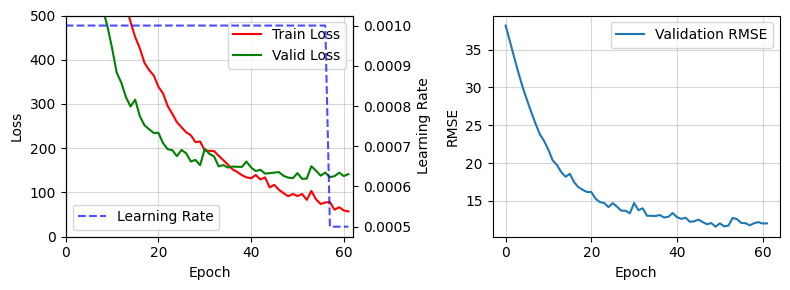

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(8, 3))
axes = axes.flatten()

axes[0].plot(history['train_loss'], label='Train Loss', c='r')
axes[0].plot(history['valid_loss'], label='Valid Loss', c='g')
axes[0].legend(loc = 'upper right')
axes[0].set_ylabel('Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_xlim(0, 62)
axes[0].set_ylim(0, 500)

ax1 = axes[0].twinx()
ax1.plot(history['learning_rate'], label='Learning Rate', c='b', ls='--', alpha=0.7)
ax1.set_ylabel('Learning Rate')
ax1.set_xlabel('Epoch')
ax1.legend(loc='lower left')

axes[1].plot(history['val_rmse'], label='Validation RMSE')
axes[1].legend(loc='upper right')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epoch')
axes[0].grid(True,alpha=0.5)
axes[1].grid(True,alpha=0.5)

plt.tight_layout()
plt.show()


In [29]:
data.describe()

,Dry_Green_g,Dry_Total_g,GDM_g
count,357.000000,357.000000,357.000000
mean,26.624722,45.318097,33.274414
std,25.401232,27.984015,24.935822
min,0.000000,1.040000,1.040000
25%,8.800000,25.271500,16.026100
50%,20.800000,40.300000,27.108200
75%,35.083400,57.880000,43.675700
max,157.983600,185.700000,157.983600


In [30]:
history_pd = pd.DataFrame(history)
history_pd.to_csv(os.path.join(model_dir, 'history_dinov2_small.csv'), index=False)

In [12]:
def eval_testds(model, loader, device):
    model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model_dinov2_small.pth'))) 
    model.to(device)

    pred_list , targ_list = [], []
    with torch.no_grad():
        pbar = tqdm(loader, desc='Testing')
        for img, tar in pbar:
            img = img.to(device); tar = tar.to(device)
            pred = model(img)
            pred_list.append(pred.cpu())
            targ_list.append(tar.cpu())

        pred_list = torch.cat(pred_list, dim=0).numpy()
        targ_list = torch.cat(targ_list, dim=0).numpy()
    return pred_list, targ_list

model = get_dino(dinov2, patch_dim=384, num_targets=3)
pred_list, targ_list = eval_testds(model, test_loader, device)

for i in range(len(test_data)):
    display( pd.DataFrame( { 'predicted': pred_list[i,:], 'target': targ_list[i,:] } ) )
    

Testing: 100%|██████████| 1/1 [00:00<00:00,  1.17it/s]


,predicted,target
0,12.360754,12.035400
1,34.377716,21.262501
2,16.527092,12.837700


,predicted,target
0,11.284604,8.9400
1,22.818008,14.9000
2,21.179504,10.9267


,predicted,target
0,12.922947,10.603900
1,34.031578,28.385900
2,20.217438,21.860399


,predicted,target
0,9.825516,17.560101
1,38.137474,64.487900
2,14.188145,18.434700


,predicted,target
0,57.716850,74.059303
1,83.256004,157.899994
2,65.383270,74.059303


,predicted,target
0,14.857905,20.533300
1,39.999786,51.333302
2,16.975666,20.533300


,predicted,target
0,29.359264,28.377001
1,45.336922,51.686699
2,34.419235,43.578999


,predicted,target
0,17.234688,27.014601
1,48.351311,68.076698
2,22.257053,27.374800


In [13]:
pred_list

array([[12.360754, 34.377716, 16.527092],
       [11.284604, 22.818008, 21.179504],
       [12.922947, 34.031578, 20.217438],
       [ 9.825516, 38.137474, 14.188145],
       [57.71685 , 83.256004, 65.38327 ],
       [14.857905, 39.999786, 16.975666],
       [29.359264, 45.33692 , 34.419235],
       [17.234688, 48.35131 , 22.257053]], dtype=float32)

In [14]:
print(f"rmse: {np.sqrt(np.mean((pred_list - targ_list)**2, axis=0))}")

rmse: [ 7.637917 29.771015  6.495066]


In [15]:
sel_target = ['Dry_Green_g', 'Dry_Total_g', 'GDM_g']

In [16]:
targ_list[:,1]

array([ 21.2625,  14.9   ,  28.3859,  64.4879, 157.9   ,  51.3333,
        51.6867,  68.0767], dtype=float32)

In [18]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

for i in range(len(sel_target)):

    true_target = targ_list[:,i]
    pred_target = pred_list[:,i]
    # true_target = test_data[tar].values
    # pred_target = all_test_preds[:, i]

    mse = mean_squared_error(true_target, pred_target) 
    rmse = np.sqrt(mse)
    r2 = r2_score(true_target, pred_target)
    mae = mean_absolute_error(true_target, pred_target)
    print(f"-- target: {sel_target[i]}")
    print(f" mean: {np.mean(true_target):.2f}")
    print(f" rmse: {rmse:.2f}")
    print(f" r2: {r2:.2f}")
    print(f" mae: {mae:.2f}")

-- target: Dry_Green_g
 mean: 24.89
 rmse: 7.64
 r2: 0.85
 mae: 5.69
-- target: Dry_Total_g
 mean: 57.25
 rmse: 29.77
 r2: 0.50
 mae: 20.64
-- target: GDM_g
 mean: 28.70
 rmse: 6.50
 r2: 0.89
 mae: 5.79
